# Submit Your Early Assignment

Complete the assignment by following the steps outlined below. Save and submit your work as an ipynb file when finished. You are expected to complete this assignment in under one hour.

## Step 0: Download the Image from the Given URL, setting up Notebooks
Retrieve the image from this link: [The Mysterious Painting](https://upload.wikimedia.org/wikipedia/en/7/74/PicassoGuernica.jpg)

Next, go through each of the three provided notebooks. Combine them into a new notebook and configure your environment according to the specifications for the tasks below.


In [1]:
!pip install --upgrade -q git+https://github.com/huggingface/transformers sentencepiece

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 28.2 MB/s eta 0:00:00


In [2]:
from transformers import AutoProcessor, AutoModel

processor = AutoProcessor.from_pretrained("google/siglip-so400m-patch14-384")
model = AutoModel.from_pretrained("google/siglip-so400m-patch14-384")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/711 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/576 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.51G [00:00<?, ?B/s]

HOME: /content
/content
/content/data


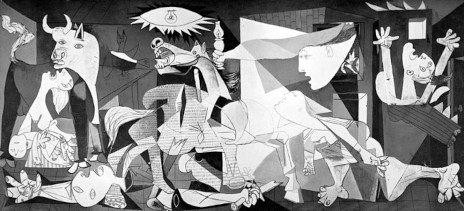

In [3]:
from PIL import Image
import os
HOME = os.getcwd()
print("HOME:", HOME)

%cd {HOME}
!mkdir {HOME}/data
%cd {HOME}/data

!wget -q https://upload.wikimedia.org/wikipedia/en/7/74/PicassoGuernica.jpg

IMAGE_NAME = "PicassoGuernica.jpg"
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

image = Image.open(IMAGE_PATH).convert("RGB")
image

## Step 1: Artist Recognition with the SigLip Model
Utilize the SigLIP model(CLIP with Sigmoid activation) to identify the artist of the painting from the list of artists provided below. Display the prediction accuracy. The expected output is the artist's name, denoted as [ARTIST].

Use the following Possible Artist Descriptions for zero-shot classification:
```python
descriptions = [
  "a painting by Leonardo da Vinci",
  "a painting by Michelangelo",
  "a painting by Vincent van Gogh",
  "a painting by Pablo Picasso",
  "a painting by Rembrandt",
  "a painting by Claude Monet"
]
```

In [4]:
descriptions = [
  "a painting by Leonardo da Vinci",
  "a painting by Michelangelo",
  "a painting by Vincent van Gogh",
  "a painting by Pablo Picasso",
  "a painting by Rembrandt",
  "a painting by Claude Monet"
]
# important: we pass padding="max_length" as that's how the model was trained
inputs = processor(text=descriptions, images=image, padding="max_length", return_tensors="pt")
for k,v in inputs.items():
  print(k,v.shape)

input_ids torch.Size([6, 64])
pixel_values torch.Size([1, 3, 384, 384])


In [5]:
import torch

with torch.no_grad():
  outputs = model(**inputs)

logits_per_image = outputs.logits_per_image
probs = torch.sigmoid(logits_per_image) # these are the probabilities

In [6]:
from IPython.core.display import display, HTML

descs = list(descriptions)
text_probs = probs[0].cpu().numpy() * 100

# Find the index of the maximum probability
max_index = text_probs.argmax()

for i, (desc, prob) in enumerate(zip(descs, text_probs)):
  if i == max_index:
    display(HTML(f"<span style='color: red;'>{desc}: {prob:.2f}%</span>"))
    ARTIST = desc.split("by ")[-1]
  else:
    print(f"{desc}: {prob:.2f}%")

a painting by Leonardo da Vinci: 0.00%
a painting by Michelangelo: 0.00%
a painting by Vincent van Gogh: 0.00%


a painting by Rembrandt: 0.00%
a painting by Claude Monet: 0.00%


In [7]:
print(f"{ARTIST}")

Pablo Picasso


## Step 2: Style-Based Object or Scene Generation
Once you've identified the [ARTIST], use this information to run the Stable Diffusion model. Create an object or scene (of your choice) inspired by the style of the identified artist. The output for this step should be an image, labeled as [GEN_IMAGE].

In [8]:
!nvidia-smi

Mon Sep  9 02:31:27 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [9]:
!pip install diffusers==0.30.2
!pip install transformers scipy ftfy accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 kB 3.8 MB/s eta 0:00:00


In [10]:
import torch
from diffusers import StableDiffusionXLPipeline

pipe = StableDiffusionXLPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, variant="fp16")

model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

scheduler/scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [11]:
pipe = pipe.to("cuda")

  0%|          | 0/50 [00:00<?, ?it/s]

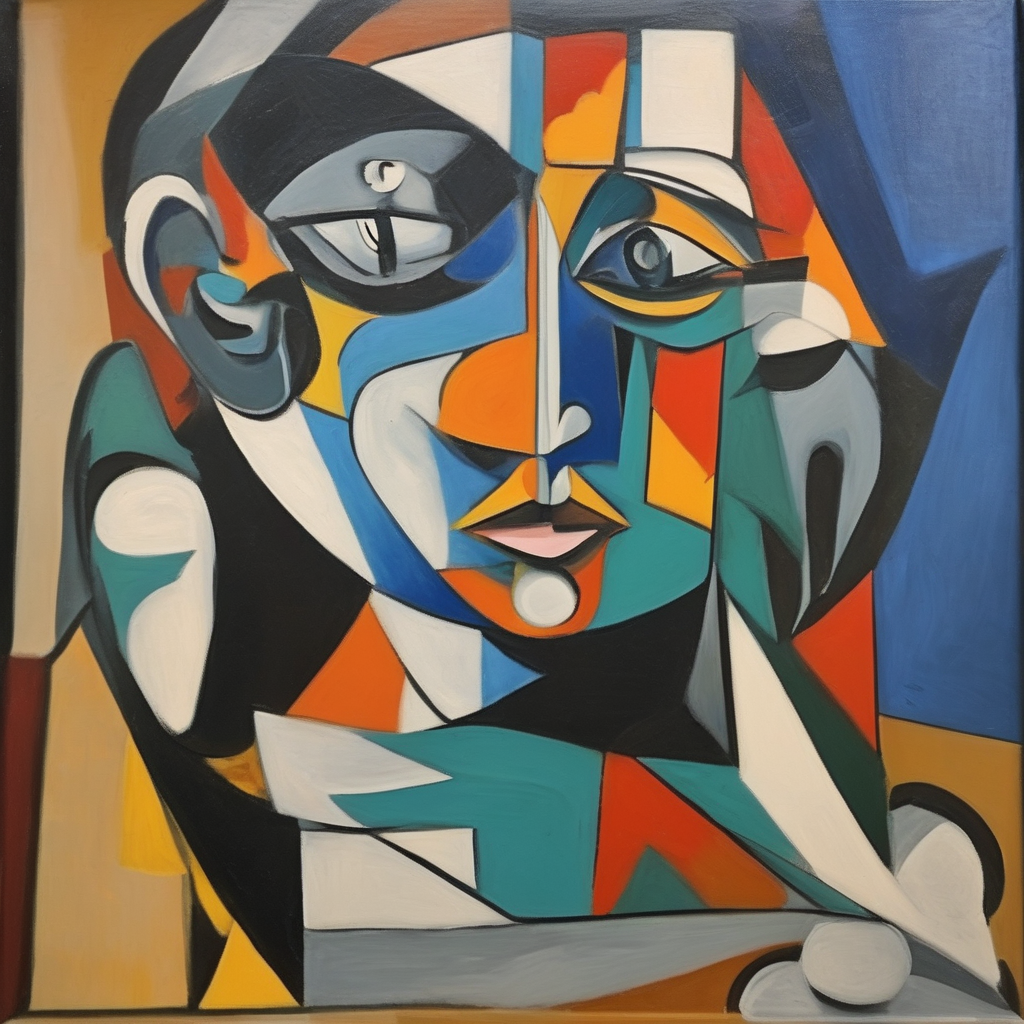

In [19]:
prompt = "A painting in the style of " + ARTIST
GEN_IMAGE = pipe(prompt).images[0]  # image here is in [PIL format](https://pillow.readthedocs.io/en/stable/)

# Now to display an image you can either save it such as:
GEN_IMAGE_NAME = f"picasso_image.png"
GEN_IMAGE.save(GEN_IMAGE_NAME)

# or if you're in a google colab you can directly display it with
GEN_IMAGE

## Step 3: Image Segmentation with SAM Model
Take the generated image [GEN_IMAGE] from the previous step, and apply the SAM model for image segmentation. Present the segmentation masks. The result of this task should be a segmented image, denoted as [SEGMENT]. If you face issues such as CUDA running out of memory during SAM step, try to resize the image to a smaller scale before SAM.

In [20]:
%cd {HOME}

import sys
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

/content
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-95157psq
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-95157psq
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 526fd066dea338ba2ca08886853bd37ffd6a8aec
  Preparing metadata (setup.py) ... done


In [21]:
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

In [22]:
%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/content
mkdir: cannot create directory ‘/content/weights’: File exists
/content/weights


In [23]:
import os

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


In [24]:
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [25]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

/usr/local/lib/python3.10/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [26]:
mask_generator = SamAutomaticMaskGenerator(sam)

In [27]:
import cv2
import supervision as sv

#Image 1 segmentation
GEN_IMAGE_PATH = os.path.join(HOME, "data", GEN_IMAGE_NAME)

image_bgr = cv2.imread(GEN_IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

sam_result = mask_generator.generate(image_rgb)

In [28]:
print(sam_result[0].keys())

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


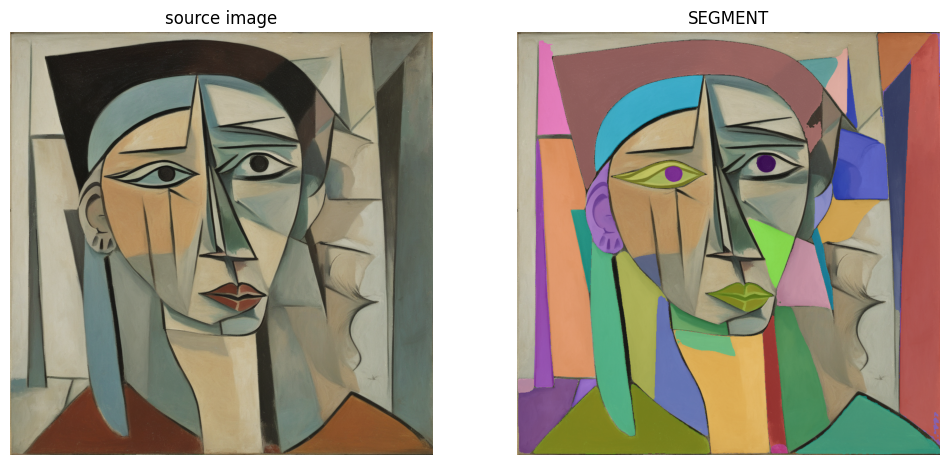

In [31]:
mask_annotator = sv.MaskAnnotator(color_lookup = sv.ColorLookup.INDEX)

detections = sv.Detections.from_sam(sam_result=sam_result)

SEGMENT = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, SEGMENT],
    grid_size=(1, 2),
    titles=['source image', 'SEGMENT']
)